In [1]:
from os.path import join
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

import torch
import transformers as ppb

import h5py
from pandas import HDFStore
import matplotlib.pyplot as plt
import seaborn as sns

from molecule_gym.config import DATA_DIR

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/home/pranjal/venvs/molecule_gym/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importing the raw dataset

Loading the raw dataset into a dataframe.

In [2]:
h5file = HDFStore(join(DATA_DIR, 'chemberta2_blood_brain_barrier_permeability.h5'), mode='r')

In [3]:
h5file.keys()

['/bbbp_raw']

In [4]:
data = h5file.get('/bbbp_raw')

In [5]:
h5file.close()

In [6]:
data.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [7]:
labels = data['p_np']
labels.value_counts()

p_np
1    1567
0     483
Name: count, dtype: int64

## Load pre-saved features from ChemBERTa-2

In [8]:
f = h5py.File(join(DATA_DIR, 'chemberta2_blood_brain_barrier_permeability.h5'), 'r')

In [9]:
f.keys()

<KeysViewHDF5 ['bbbp_raw', 'chemberta_2_features']>

In [10]:
features = f.get('chemberta_2_features')

In [12]:
features.shape

(2050, 7924)

In [32]:
# Distribution description of a feature sample
features_describe = pd.DataFrame(features[0,:])
features_describe.describe()

,0
count,7924.000000
mean,-6.741820
std,1.530230
min,-10.536302
25%,-7.563511
50%,-6.983957
75%,-6.325683
max,7.956779


## Feature reduction with PCA Analysis

In [13]:
from sklearn.decomposition import PCA
pca = PCA()

In [14]:
features_transformed = pca.fit_transform(features)

In [15]:
exp_var_pca = pca.explained_variance_ratio_[:20]
exp_var_pca

array([0.5938465 , 0.10870522, 0.07596859, 0.03343878, 0.02153103,
       0.01561497, 0.01211777, 0.01090148, 0.00931212, 0.00752243,
       0.00695139, 0.00620874, 0.00573067, 0.00467514, 0.00443109,
       0.00391127, 0.00385056, 0.00366863, 0.00342663, 0.00282674],
      dtype=float32)

In [16]:
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
cum_sum_eigenvalues

array([0.5938465 , 0.7025517 , 0.7785203 , 0.8119591 , 0.83349013,
       0.8491051 , 0.86122286, 0.8721243 , 0.8814364 , 0.8889588 ,
       0.8959102 , 0.9021189 , 0.9078496 , 0.91252476, 0.9169558 ,
       0.9208671 , 0.92471766, 0.9283863 , 0.9318129 , 0.93463963],
      dtype=float32)

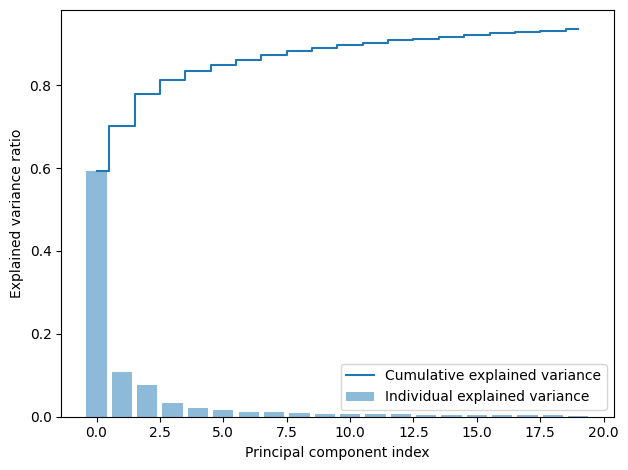

In [17]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [18]:
features_reduced = features_transformed[:,:20]

In [19]:
features_reduced.shape

(2050, 20)

## Oversampling the smallest class

In [20]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(features_reduced, labels)

In [21]:
train_features, test_features, train_labels, test_labels = train_test_split(X_res, y_res, test_size=0.3)

In [22]:
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(test_labels)}")

Training target statistics: Counter({1: 1567, 0: 1567})
Testing target statistics: Counter({0: 484, 1: 457})


In [23]:
lr_clf = SVC()
lr_clf.fit(train_features, train_labels)

SVC()

In [24]:
lr_clf.score(test_features, test_labels)

0.8544102019128587

In [25]:
train_pred = lr_clf.predict(train_features)

In [33]:
print('TRAINING STATISTICS:')
print(classification_report(train_labels, train_pred))

TRAINING STATISTICS:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1083
           1       0.88      0.83      0.85      1110

    accuracy                           0.86      2193
   macro avg       0.86      0.86      0.86      2193
weighted avg       0.86      0.86      0.86      2193



In [34]:
print('Model performance on test data:')
predictions = lr_clf.predict(test_features)
print(classification_report(test_labels, predictions))

Model performance on test data:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       484
           1       0.87      0.82      0.85       457

    accuracy                           0.85       941
   macro avg       0.86      0.85      0.85       941
weighted avg       0.86      0.85      0.85       941



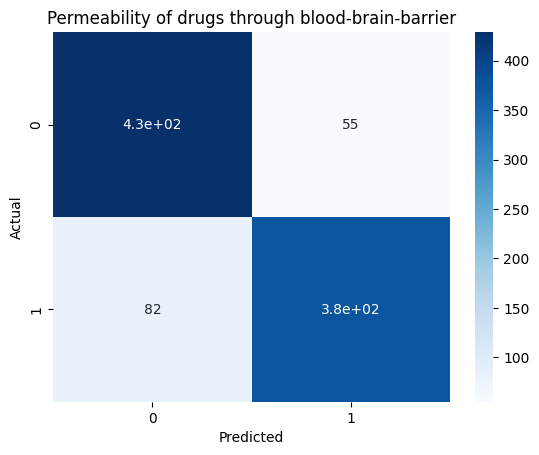

In [36]:
cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Permeability of drugs through blood-brain-barrier')
plt.show()